<a href="https://colab.research.google.com/github/lealec1234/Event_camera_object_detection_tracking/blob/main/SORT_tracking_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Import packages and datasets

In [2]:
!pip install datatable

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96.9 MB 1.2 MB/s 


In [3]:
import os
import matplotlib.pyplot as plt
import sys
import random
import h5py
import numpy as np
import warnings
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from PIL import Image
from matplotlib import gridspec
import matplotlib.image as im
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import datatable as dtable
import os, gc, glob
import cv2
import subprocess
import pandas as pd
from numba import njit
from tqdm.notebook import tqdm
import matplotlib.cm as cm
from matplotlib import animation
from IPython.display import HTML

In [4]:
%cd "/content/drive/MyDrive/honours project/Event_Camera/dataset_dir/DAVIS 240C Dataset"  
#go to the directory of the dataset

/content/drive/MyDrive/honours project/Event_Camera/dataset_dir/DAVIS 240C Dataset


#Kalman filter

In [6]:
#code from https://github.com/RahmadSadli/2-D-Kalman-Filter/blob/master/KalmanFilter.py
class Kalman:
	"""
	USAGE:
	
	# e.g., tracking an (x,y) point over time
	k = Kalman(state_dim = 6, obs_dim = 2)
	
	# when you get a new observation — 
	someNewPoint = np.r_[1,2]
	k.update(someNewPoint)
	
	# and when you want to make a new prediction
	predicted_location = k.predict()
	
	NOTE: 
	Setting state_dim to 3*obs_dim automatically implements a simple
	acceleration-based model, i.e.
	x(t+1) = x(t) + v(t) + a(t)/2
	
	"""
	import numpy as np
	def __init__(self, state_dim, obs_dim):
		self.state_dim = state_dim
		self.obs_dim   = obs_dim
		
		self.Q 		 = np.matrix( np.eye(state_dim)*1e-4 )			  # Process noise
		self.R		 = np.matrix( np.eye(obs_dim)*0.01 )			  # Observation noise
		self.A		 = np.matrix( np.eye(state_dim) )			  # Transition matrix
		self.H		 = np.matrix( np.zeros((obs_dim, state_dim)) )		  # Measurement matrix
		self.K		 = np.matrix( np.zeros_like(self.H.T) )			  # Gain matrix
		self.P		 = np.matrix( np.zeros_like(self.A) )			  # State covariance
		self.x		 = np.matrix( np.zeros((state_dim, 1)) )		  # The actual state of the system
	
		if obs_dim == state_dim/3:
			# We'll go ahead and make this a position-predicting matrix with velocity & acceleration if we've got the right combination of dimensions
			# The model is : x( t + 1 ) = x( t ) + v( t ) + a( t ) / 2

			idx = np.r_[0:obs_dim]
			positionIdx = np.ix_(idx, idx)
			velocityIdx = np.ix_(idx,idx+obs_dim)
			accelIdx	= np.ix_(idx, idx+obs_dim*2)
			accelAndVelIdx = np.ix_(idx+obs_dim, idx+obs_dim*2)
			
			self.H[positionIdx]		= np.eye(obs_dim)
			self.A				= np.eye(state_dim)
			self.A[velocityIdx]		+= np.eye(obs_dim)
			self.A[accelIdx]		+= 0.5 * np.eye(obs_dim)
			self.A[accelAndVelIdx]  	+= np.eye(obs_dim)
			
	def update(self, obs):
		
		if obs.ndim == 1:
			obs = np.matrix(obs).T
		
		# Make prediction
		self.x	= self.A * self.x
		self.P	= self.A * self.P * self.A.T + self.Q
		
		# Compute the optimal Kalman gain factor
		self.K = self.P * self.H.T * np.linalg.inv(self.H * self.P * self.H.T + self.R)
		
		# Correction based on observation
		self.x = self.x + self.K * ( obs - self.H * self.x )
		self.P = self.P - self.K * self.H * self.P


	def predict(self):
		return np.asarray(self.H*self.x)

In [37]:
#data association function
import matplotlib.patches as patches
import math
import inspect
class BoxTracker:
    def __init__(self):
        # Store the center positions of the objects
        self.center_points = {}
        self.same_id_count = 1
        # Keep the count of the IDs
        # each time a new object id detected, the count will increase by one
        self.id_count = 1


    def update(self, objects_rect):
        
        # Objects boxes and ids
        objects_bbs_ids = []

        # Get center point of new object
        for rect in objects_rect:
            x, y, w, h = rect
            cx = (x + x + w) // 2
            cy = (y + y + h) // 2
            #store bounding box coordinates into a variable
            current_boundingbox = get_bounding_box_points(y,x,w,h)
       #     print(current_boundingbox)
            #create list of iou compared with all other bounding boxes
            list_of_iou = []
            # Find out if that object was detected already
            same_object_detected = False
            for id, pt in self.center_points.items():
                dist = math.hypot(cx - pt[0], cy - pt[1])


                #compare the iou of current box with all other bounding boxes
                #get coordinates of bounding box
                detected_boxes = get_bounding_box_points(pt[1],pt[0],w,h)
          #      print(detected_boxes)
                iou = get_iou(current_boundingbox,detected_boxes)     
                list_of_iou.append([iou])
                #if iou<0.5 reject assignment
                if dist < 40 or iou >0.5:
                  self.center_points[id] = (cx, cy)
           #       print(self.center_points)
                  objects_bbs_ids.append([x, y, w, h, id])
                  self.same_id_count += 1
                  same_object_detected = True
                  break
            # New object is detected we assign the ID to that object
            if same_object_detected is False:
                self.center_points[self.id_count] = (cx, cy)

                objects_bbs_ids.append([x, y, w, h, self.id_count])
                self.id_count += 1
            # Clean the dictionary by center points to remove IDS not used anymore
        new_center_points = {}

        for obj_bb_id in objects_bbs_ids:
            _, _, _, _, object_id = obj_bb_id
            center = self.center_points[object_id]
            new_center_points[object_id] = center
        # Update dictionary with IDs not used removed
        self.center_points = new_center_points.copy()
        
        return objects_bbs_ids

In [38]:
def get_iou(a, b, epsilon=1e-5):
    """ Given two boxes `a` and `b` defined as a list of four numbers:
            [x1,y1,x2,y2]
        where:
            x1,y1 represent the upper left corner
            x2,y2 represent the lower right corner
        It returns the Intersect of Union score for these two boxes.

    Args:
        a:          (list of 4 numbers) [x1,y1,x2,y2]
        b:          (list of 4 numbers) [x1,y1,x2,y2]
        epsilon:    (float) Small value to prevent division by zero

    Returns:
        (float) The Intersect of Union score.
    """
    # COORDINATES OF THE INTERSECTION BOX
    x1 = max(a[0], b[0])
    y1 = min(a[1], b[1])
    x2 = min(a[2], b[2])
    y2 = max(a[3], b[3])

    # AREA OF OVERLAP - Area where the boxes intersect
    width = (x2 - x1)
    height = (y1 - y2)
    # handle case where there is NO overlap
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height

    # COMBINED AREA
    area_a = (a[2] - a[0]) * (a[1] - a[3])
    area_b = (b[2] - b[0]) * (b[1] - b[3])
    area_combined = area_a + area_b - area_overlap

    # RATIO OF AREA OF OVERLAP OVER COMBINED AREA
    iou = area_overlap / (area_combined+epsilon)
    return iou

In [39]:
def get_bounding_box_points(y, x, width, height):
  # x and y are the coordinates of the bottom left corner

  #top left corner:
  top_left_x = x
  top_left_y = y + height

  #bottom right corner:
  bottom_right_x = x + width
  bottom_right_y = y

  return top_left_x, top_left_y, bottom_right_x, bottom_right_y

#SORT algorithm + cars dataset

1


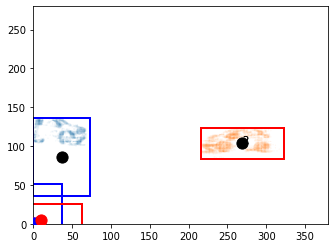

2


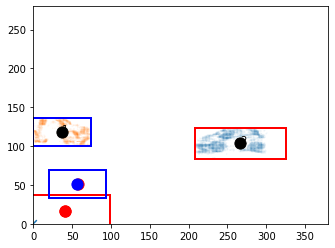

3


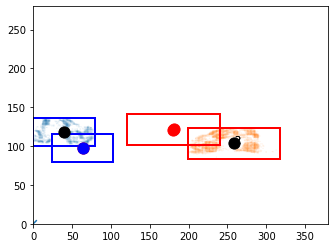

4


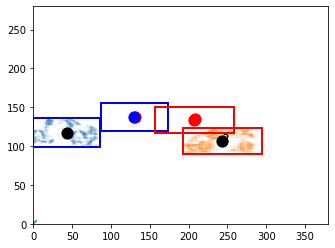

5


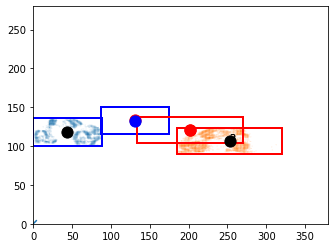

6


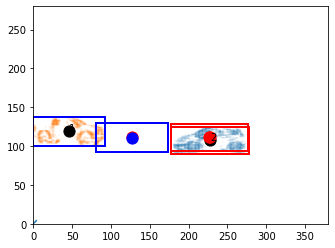

7


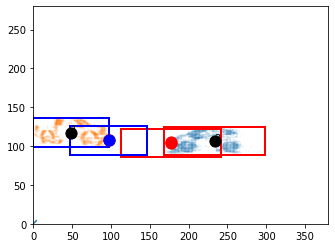

8


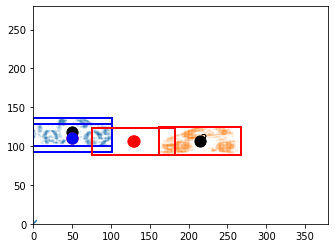

9


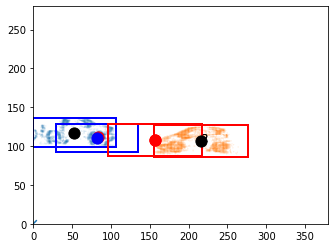

10


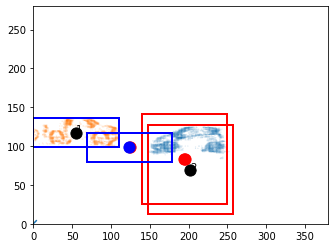

11


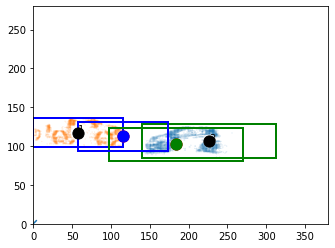

12


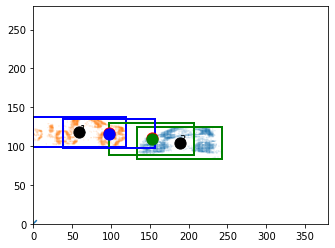

13


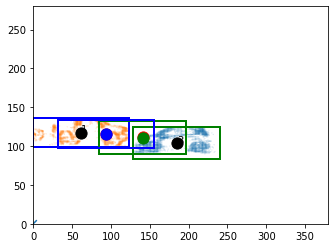

14


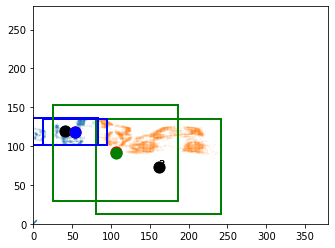

15


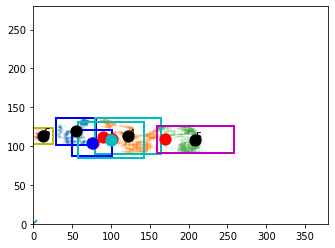

In [42]:
#Load box tracker for data association
boxtracker = BoxTracker()

#Load kalman filter for predict bounding boxes
k = Kalman(state_dim = 6, obs_dim = 2)

for i in range(1,16):
  boxes = []
  predictedboxes = []

  print(i)
  yy = str(i)
  file_name = yy
  selected_events = np.load("results/davis240/cars/selected_events/"+file_name+".npy")
  cluster = np.load("results/davis240/cars/clusters/"+file_name+".npy")
  #set plot axis values
  fig,ax = plt.subplots()

  ax.plot(range(5))
  plt.xlim(0, 380)
  plt.ylim(0, 280)
  plt.gca().set_aspect('equal', adjustable='box')
  x = np.array(selected_events[:, 0])
  x = 260-x
  y = np.array(selected_events[:, 1])
  y = 346-y
  z = np.array(selected_events[:, 2]*100)

  for i in range(0,9):
    #this for loop finds the center of each of the clusters and appends value into boxes array for euclidean class to 
    #create a unique id for each bounding box class
    small1 = -999
    small2 = 999
    for ele1 in y[np.where(cluster == i, True, False)]:
      if(ele1 > small1):
        small1 = ele1

    for ele2 in x[np.where(cluster == i, True, False)]:
      if(ele2 < small2):
        small2 = ele2

    big1 = 999
    big2 = 999
    for ele3 in y[np.where(cluster == i, True, False)]:
      if(ele3 < big1):
        big1 = ele3

    for ele4 in x[np.where(cluster == i, True, False)]:
      if(ele4 < big2):
        big2 = ele4

    height1 = 999
    height2 = -999
    for ele1 in y[np.where(cluster == i, True, False)]:
      if(ele1 < height1):
        height1 = ele1

    for ele2 in x[np.where(cluster == i, True, False)]:
      if(ele2 > height2):
        height2 = ele2

    #x,y top left, w = width , h = height
    width = int(small1)-int(big1)
    height = int(height2)-int(big2)
    small1 = int(small1)
    small1 = int(small2)
    big1 = int(big1)
    big2 = int(big2)

    centerx = big2 + height/2
    centery = big1 + width/2

    
   #filter out all the noised detections
    if centerx > 0 and centery > 0:
      #print the detected objects
      plt.scatter(centery, centerx, marker = ".", s=500, color = "black", zorder=3)
  #    print(centery,centerx)

      #draw bounding box
  #    rect = patches.Rectangle((int(big1),int(big2)),width,height, fill=False, edgecolor='blue',lw=2)
  #    ax.add_patch(rect)

      #for detected object add the object into update function and then predict the location using kalman filter
      someNewPoint = np.r_[centery,centerx]
      k.update(someNewPoint)
      predicted_location = k.predict()

      #create dot at predicted location
      plt.scatter(predicted_location[0], predicted_location[1], marker = ".", s=500, color = "red", zorder=3)
  #    print("predicted location: ", predicted_location[0], predicted_location[1])
  #    print(predicted_location[0],predicted_location[1])

      #Convert centre to bounding box
      predicted_coordinate1 = predicted_location[1] - height/2
      predicted_coordinate2 = predicted_location[0] - width/2

      #store the boxes into array
      boxes.append([int(big1), int(big2), width, height])

      #store the predicted boxes into array
      predictedboxes.append([int(predicted_coordinate2), int(predicted_coordinate1), width, height])
#update the box tracker with both predicted boxes and normal boxes
  box_tracker = boxtracker.update(boxes)

  count = []
  filtered =[]
  for i in range(len(box_tracker)):
        if(box_tracker[i][4] not in count and box_tracker[i][0] < 800):
            count.append(box_tracker[i][4])
            filtered.append(box_tracker[i])

  id1=id2=id3=id4=id5=id6=id7=id8=0

  for box_id in filtered:
          xcoord, ycoord, w, h, id = box_id
          if(id == 1):
            rect = patches.Rectangle((xcoord,ycoord),w,h, fill=False, edgecolor='b',lw=2)
            ax.add_patch(rect)
            id1 = w
          if(id ==2):
            rect = patches.Rectangle((xcoord,ycoord),w,h, fill=False, edgecolor='r',lw=2)
            ax.add_patch(rect)
            plt.text(xcoord+(w/2),ycoord+(h/2), id)
            id2 = w
          if(id ==3):
            rect = patches.Rectangle((xcoord,ycoord),w,h, fill=False, edgecolor='g',lw=2)
            ax.add_patch(rect)
            plt.text(xcoord+(w/2),ycoord+(h/2), id)
            id3 = w
          if(id ==4):
            rect = patches.Rectangle((xcoord,ycoord),w,h, fill=False, edgecolor='c',lw=2)
            ax.add_patch(rect)
            plt.text(xcoord+(w/2),ycoord+(h/2), id)
            id4 = w
          if(id ==5):
            rect = patches.Rectangle((xcoord,ycoord),w,h, fill=False, edgecolor='m',lw=2)
            ax.add_patch(rect)
            plt.text(xcoord+(w/2),ycoord+(h/2), id)
          if(id ==6):
            rect = patches.Rectangle((xcoord,ycoord),w,h, fill=False, edgecolor='y',lw=2)
            ax.add_patch(rect)
            plt.text(xcoord+(w/2),ycoord+(h/2), id)
          if(id ==7):
            rect = patches.Rectangle((xcoord,ycoord),w,h, fill=False, edgecolor='k',lw=2)
            ax.add_patch(rect)
            plt.text(xcoord+(w/2),ycoord+(h/2), id)
          if(id ==8):
            rect = patches.Rectangle((xcoord,ycoord),w,h, fill=False, edgecolor='purple',lw=2)
            ax.add_patch(rect)
            plt.text(xcoord+(w/2),ycoord+(h/2), id)     

#prints predicted boxes
  for pred in predictedboxes: 
    xpred,ypred,wpred,hpred = pred     
     
    centrex = ypred + hpred/2
    centrey = xpred + wpred/2

    if(id1 == wpred):
      rect = patches.Rectangle((xpred,ypred),wpred,hpred, fill=False, edgecolor='b',lw=2)
      ax.add_patch(rect)
      plt.scatter(centrey, centrex, marker = ".", s=500, color = "blue", zorder=3)
      
    if(id2 == wpred):
      rect = patches.Rectangle((xpred,ypred),wpred,hpred, fill=False, edgecolor='r',lw=2)
      ax.add_patch(rect)
      plt.text(xcoord+(w/2),ycoord+(h/2), id)
      plt.scatter(centrey, centrex, marker = ".", s=500, color = "red", zorder=3)
      
    if(id3 == wpred):
      rect = patches.Rectangle((xpred,ypred),wpred,hpred, fill=False, edgecolor='g',lw=2)
      ax.add_patch(rect)
      plt.text(xcoord+(w/2),ycoord+(h/2), id)
      plt.scatter(centrey, centrex, marker = ".", s=500, color = "green", zorder=3)
    if(id4 == wpred):
      rect = patches.Rectangle((xpred,ypred),wpred,hpred, fill=False, edgecolor='c',lw=2)
      ax.add_patch(rect)
      plt.text(xcoord+(w/2),ycoord+(h/2), id)
      plt.scatter(centrey, centrex, marker = ".", s=500, color = "c", zorder=3)
         
  for i in range(0,9):
   plt.scatter(y[np.where(cluster == i, True, False)], x[np.where(cluster == i, True, False)], z[np.where(cluster == i, True, False)])

  

  plt.show()

# SORT algorithm + shapes dataset

1


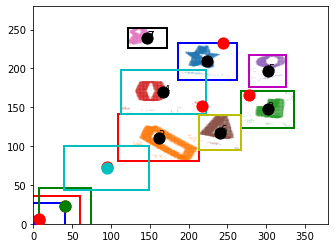

2


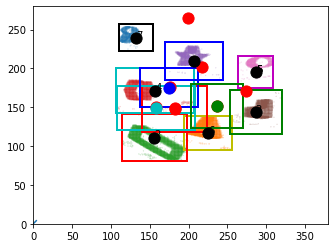

3


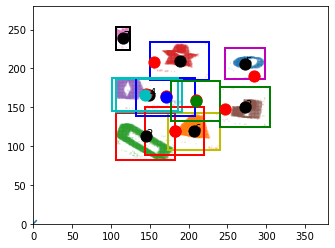

4


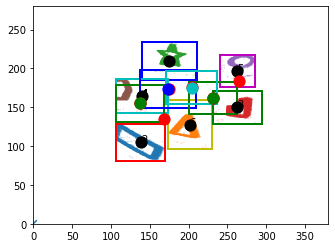

5


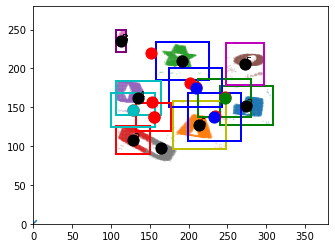

6


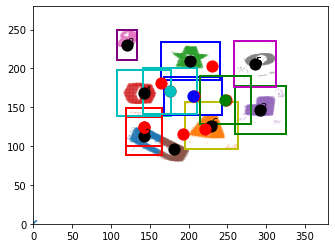

7


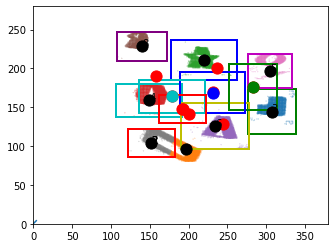

8


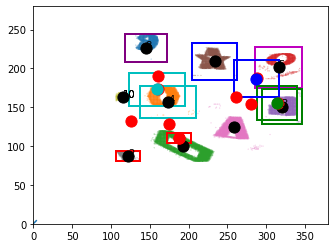

9


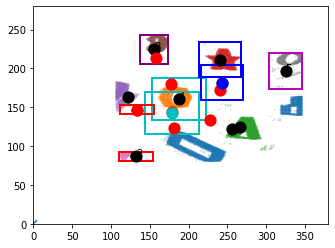

10


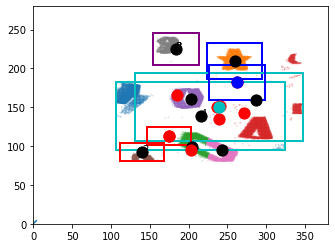

11


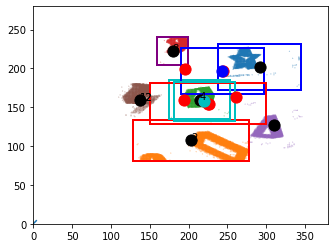

12


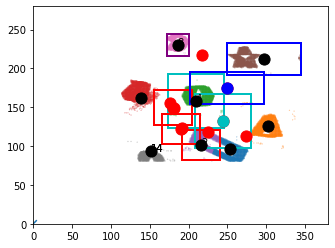

13


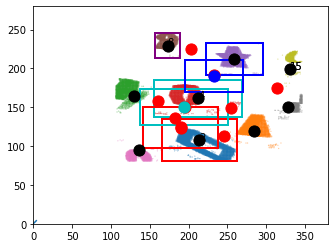

14


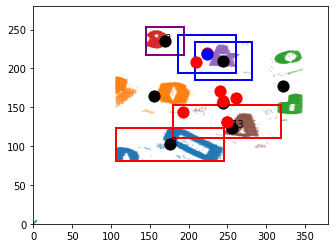

15


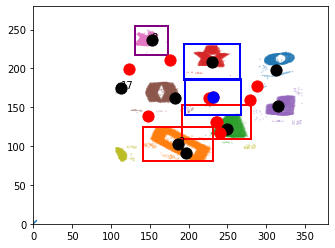

In [43]:
#Load box tracker for data association
boxtracker = BoxTracker()

#Load kalman filter for predict bounding boxes
k = Kalman(state_dim = 6, obs_dim = 2)

j=1000
for i in range(1,16):
  boxes = []
  predictedboxes = []

  print(i)
  yy = str(i)
  file_name = yy
  selected_events = np.load("results/davis240/"+str(j)+"/selected_events/"+file_name+".npy")
  cluster = np.load("results/davis240/"+str(j)+"/clusters/"+file_name+".npy")
  #set plot axis values
  fig,ax = plt.subplots()

  ax.plot(range(5))
  plt.xlim(0, 380)
  plt.ylim(0, 280)
  plt.gca().set_aspect('equal', adjustable='box')
  x = np.array(selected_events[:, 0])
  x = 260-x
  y = np.array(selected_events[:, 1])
  y = 346-y
  z = np.array(selected_events[:, 2]*100)

  for i in range(0,9):
    #this for loop finds the center of each of the clusters and appends value into boxes array for euclidean class to 
    #create a unique id for each bounding box class
    small1 = -999
    small2 = 999
    for ele1 in y[np.where(cluster == i, True, False)]:
      if(ele1 > small1):
        small1 = ele1

    for ele2 in x[np.where(cluster == i, True, False)]:
      if(ele2 < small2):
        small2 = ele2

    big1 = 999
    big2 = 999
    for ele3 in y[np.where(cluster == i, True, False)]:
      if(ele3 < big1):
        big1 = ele3

    for ele4 in x[np.where(cluster == i, True, False)]:
      if(ele4 < big2):
        big2 = ele4

    height1 = 999
    height2 = -999
    for ele1 in y[np.where(cluster == i, True, False)]:
      if(ele1 < height1):
        height1 = ele1

    for ele2 in x[np.where(cluster == i, True, False)]:
      if(ele2 > height2):
        height2 = ele2

    #x,y top left, w = width , h = height
    width = int(small1)-int(big1)
    height = int(height2)-int(big2)
    small1 = int(small1)
    small1 = int(small2)
    big1 = int(big1)
    big2 = int(big2)

    centerx = big2 + height/2
    centery = big1 + width/2

    
   #filter out all the noised detections
    if centerx > 0 and centery > 0:
      #print the detected objects
      plt.scatter(centery, centerx, marker = ".", s=500, color = "black", zorder=3)
  #    print(centery,centerx)

      #draw bounding box
  #    rect = patches.Rectangle((int(big1),int(big2)),width,height, fill=False, edgecolor='blue',lw=2)
  #    ax.add_patch(rect)

      #for detected object add the object into update function and then predict the location using kalman filter
      someNewPoint = np.r_[centery,centerx]
      k.update(someNewPoint)
      predicted_location = k.predict()

      #create dot at predicted location
      plt.scatter(predicted_location[0], predicted_location[1], marker = ".", s=500, color = "red", zorder=3)
  #    print("predicted location: ", predicted_location[0], predicted_location[1])
  #    print(predicted_location[0],predicted_location[1])

      #Convert centre to bounding box
      predicted_coordinate1 = predicted_location[1] - height/2
      predicted_coordinate2 = predicted_location[0] - width/2

      #store the boxes into array
      boxes.append([int(big1), int(big2), width, height])

      #store the predicted boxes into array
      predictedboxes.append([int(predicted_coordinate2), int(predicted_coordinate1), width, height])
#update the box tracker with both predicted boxes and normal boxes
  box_tracker = boxtracker.update(boxes)

  count = []
  filtered =[]
  for i in range(len(box_tracker)):
        if(box_tracker[i][4] not in count and box_tracker[i][0] < 800):
            count.append(box_tracker[i][4])
            filtered.append(box_tracker[i])

  id1=id2=id3=id4=id5=id6=id7=id8=0

  for box_id in filtered:
          xcoord, ycoord, w, h, id = box_id
          if(id == 1):
            rect = patches.Rectangle((xcoord,ycoord),w,h, fill=False, edgecolor='b',lw=2)
            ax.add_patch(rect)
            id1 = w
          if(id ==2):
            rect = patches.Rectangle((xcoord,ycoord),w,h, fill=False, edgecolor='r',lw=2)
            ax.add_patch(rect)
            plt.text(xcoord+(w/2),ycoord+(h/2), id)
            id2 = w
          if(id ==3):
            rect = patches.Rectangle((xcoord,ycoord),w,h, fill=False, edgecolor='g',lw=2)
            ax.add_patch(rect)
            plt.text(xcoord+(w/2),ycoord+(h/2), id)
            id3 = w
          if(id ==4):
            rect = patches.Rectangle((xcoord,ycoord),w,h, fill=False, edgecolor='c',lw=2)
            ax.add_patch(rect)
            plt.text(xcoord+(w/2),ycoord+(h/2), id)
            id4 = w
          if(id ==5):
            rect = patches.Rectangle((xcoord,ycoord),w,h, fill=False, edgecolor='m',lw=2)
            ax.add_patch(rect)
            plt.text(xcoord+(w/2),ycoord+(h/2), id)
          if(id ==6):
            rect = patches.Rectangle((xcoord,ycoord),w,h, fill=False, edgecolor='y',lw=2)
            ax.add_patch(rect)
            plt.text(xcoord+(w/2),ycoord+(h/2), id)
          if(id ==7):
            rect = patches.Rectangle((xcoord,ycoord),w,h, fill=False, edgecolor='k',lw=2)
            ax.add_patch(rect)
            plt.text(xcoord+(w/2),ycoord+(h/2), id)
          if(id ==8):
            rect = patches.Rectangle((xcoord,ycoord),w,h, fill=False, edgecolor='purple',lw=2)
            ax.add_patch(rect)
            plt.text(xcoord+(w/2),ycoord+(h/2), id)     

#prints predicted boxes
  for pred in predictedboxes: 
    xpred,ypred,wpred,hpred = pred     
     
    centrex = ypred + hpred/2
    centrey = xpred + wpred/2

    if(id1 == wpred):
      rect = patches.Rectangle((xpred,ypred),wpred,hpred, fill=False, edgecolor='b',lw=2)
      ax.add_patch(rect)
      plt.scatter(centrey, centrex, marker = ".", s=500, color = "blue", zorder=3)
      
    if(id2 == wpred):
      rect = patches.Rectangle((xpred,ypred),wpred,hpred, fill=False, edgecolor='r',lw=2)
      ax.add_patch(rect)
      plt.text(xcoord+(w/2),ycoord+(h/2), id)
      plt.scatter(centrey, centrex, marker = ".", s=500, color = "red", zorder=3)
      
    if(id3 == wpred):
      rect = patches.Rectangle((xpred,ypred),wpred,hpred, fill=False, edgecolor='g',lw=2)
      ax.add_patch(rect)
      plt.text(xcoord+(w/2),ycoord+(h/2), id)
      plt.scatter(centrey, centrex, marker = ".", s=500, color = "green", zorder=3)
    if(id4 == wpred):
      rect = patches.Rectangle((xpred,ypred),wpred,hpred, fill=False, edgecolor='c',lw=2)
      ax.add_patch(rect)
      plt.text(xcoord+(w/2),ycoord+(h/2), id)
      plt.scatter(centrey, centrex, marker = ".", s=500, color = "c", zorder=3)
         
  for i in range(0,9):
   plt.scatter(y[np.where(cluster == i, True, False)], x[np.where(cluster == i, True, False)], z[np.where(cluster == i, True, False)])

  

  plt.show()

#SORT algorithm + Hands dataset

1


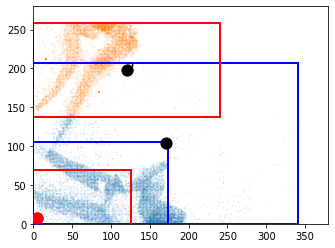

2


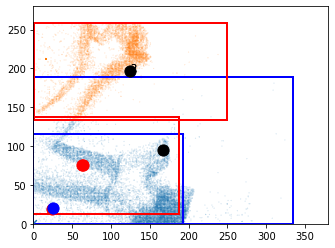

3


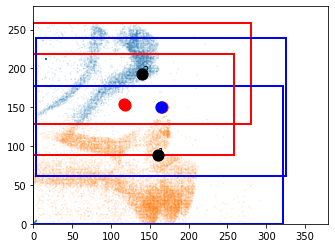

4


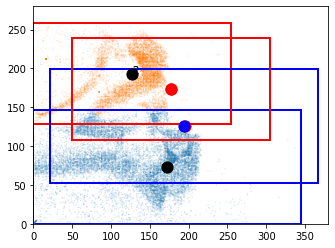

5


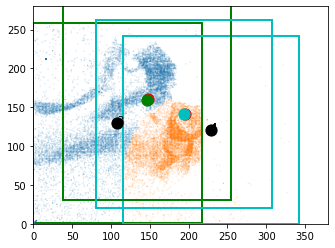

6


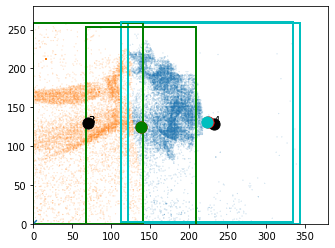

7


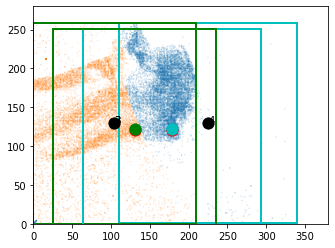

8


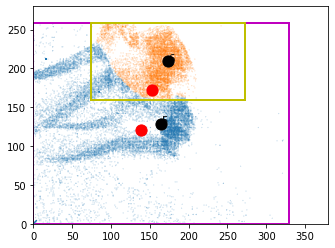

9


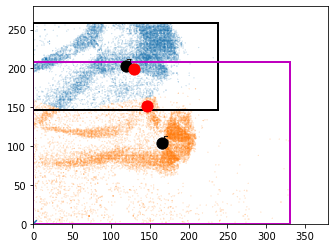

10


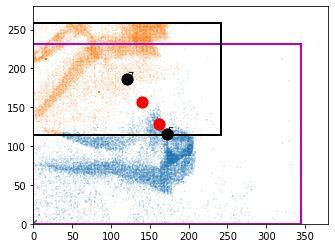

11


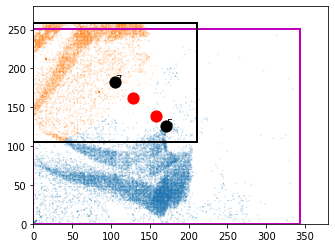

12


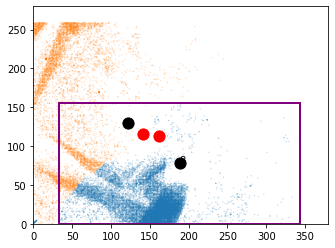

13


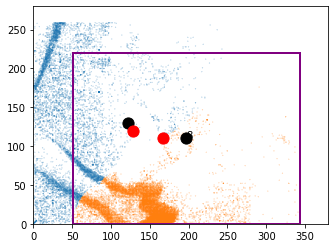

14


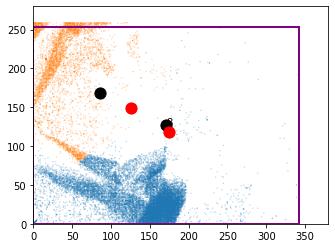

15


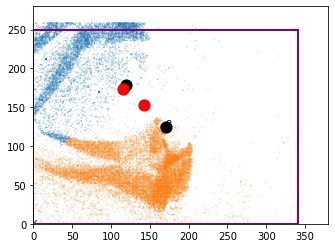

In [44]:
#Load box tracker for data association
boxtracker = BoxTracker()

#Load kalman filter for predict bounding boxes
k = Kalman(state_dim = 6, obs_dim = 2)

j=64
for i in range(1,16):
  boxes = []
  predictedboxes = []

  print(i)
  yy = str(i)
  file_name = yy
  selected_events = np.load("results/davis240/hands/"+str(j)+"/selected_events/"+file_name+".npy")
  cluster = np.load("results/davis240/hands/"+str(j)+"/clusters/"+file_name+".npy")
  #set plot axis values
  fig,ax = plt.subplots()

  ax.plot(range(5))
  plt.xlim(0, 380)
  plt.ylim(0, 280)
  plt.gca().set_aspect('equal', adjustable='box')
  x = np.array(selected_events[:, 0])
  x = 260-x
  y = np.array(selected_events[:, 1])
  y = 346-y
  z = np.array(selected_events[:, 2]*100)

  for i in range(0,9):
    #this for loop finds the center of each of the clusters and appends value into boxes array for euclidean class to 
    #create a unique id for each bounding box class
    small1 = -999
    small2 = 999
    for ele1 in y[np.where(cluster == i, True, False)]:
      if(ele1 > small1):
        small1 = ele1

    for ele2 in x[np.where(cluster == i, True, False)]:
      if(ele2 < small2):
        small2 = ele2

    big1 = 999
    big2 = 999
    for ele3 in y[np.where(cluster == i, True, False)]:
      if(ele3 < big1):
        big1 = ele3

    for ele4 in x[np.where(cluster == i, True, False)]:
      if(ele4 < big2):
        big2 = ele4

    height1 = 999
    height2 = -999
    for ele1 in y[np.where(cluster == i, True, False)]:
      if(ele1 < height1):
        height1 = ele1

    for ele2 in x[np.where(cluster == i, True, False)]:
      if(ele2 > height2):
        height2 = ele2

    #x,y top left, w = width , h = height
    width = int(small1)-int(big1)
    height = int(height2)-int(big2)
    small1 = int(small1)
    small1 = int(small2)
    big1 = int(big1)
    big2 = int(big2)

    centerx = big2 + height/2
    centery = big1 + width/2

    
   #filter out all the noised detections
    if centerx > 0 and centery > 0:
      #print the detected objects
      plt.scatter(centery, centerx, marker = ".", s=500, color = "black", zorder=3)
  #    print(centery,centerx)

      #draw bounding box
  #    rect = patches.Rectangle((int(big1),int(big2)),width,height, fill=False, edgecolor='blue',lw=2)
  #    ax.add_patch(rect)

      #for detected object add the object into update function and then predict the location using kalman filter
      someNewPoint = np.r_[centery,centerx]
      k.update(someNewPoint)
      predicted_location = k.predict()

      #create dot at predicted location
      plt.scatter(predicted_location[0], predicted_location[1], marker = ".", s=500, color = "red", zorder=3)
  #    print("predicted location: ", predicted_location[0], predicted_location[1])
  #    print(predicted_location[0],predicted_location[1])

      #Convert centre to bounding box
      predicted_coordinate1 = predicted_location[1] - height/2
      predicted_coordinate2 = predicted_location[0] - width/2

      #store the boxes into array
      boxes.append([int(big1), int(big2), width, height])

      #store the predicted boxes into array
      predictedboxes.append([int(predicted_coordinate2), int(predicted_coordinate1), width, height])
#update the box tracker with both predicted boxes and normal boxes
  box_tracker = boxtracker.update(boxes)

  count = []
  filtered =[]
  for i in range(len(box_tracker)):
        if(box_tracker[i][4] not in count and box_tracker[i][0] < 800):
            count.append(box_tracker[i][4])
            filtered.append(box_tracker[i])

  id1=id2=id3=id4=id5=id6=id7=id8=0

  for box_id in filtered:
          xcoord, ycoord, w, h, id = box_id
          if(id == 1):
            rect = patches.Rectangle((xcoord,ycoord),w,h, fill=False, edgecolor='b',lw=2)
            ax.add_patch(rect)
            id1 = w
          if(id ==2):
            rect = patches.Rectangle((xcoord,ycoord),w,h, fill=False, edgecolor='r',lw=2)
            ax.add_patch(rect)
            plt.text(xcoord+(w/2),ycoord+(h/2), id)
            id2 = w
          if(id ==3):
            rect = patches.Rectangle((xcoord,ycoord),w,h, fill=False, edgecolor='g',lw=2)
            ax.add_patch(rect)
            plt.text(xcoord+(w/2),ycoord+(h/2), id)
            id3 = w
          if(id ==4):
            rect = patches.Rectangle((xcoord,ycoord),w,h, fill=False, edgecolor='c',lw=2)
            ax.add_patch(rect)
            plt.text(xcoord+(w/2),ycoord+(h/2), id)
            id4 = w
          if(id ==5):
            rect = patches.Rectangle((xcoord,ycoord),w,h, fill=False, edgecolor='m',lw=2)
            ax.add_patch(rect)
            plt.text(xcoord+(w/2),ycoord+(h/2), id)
          if(id ==6):
            rect = patches.Rectangle((xcoord,ycoord),w,h, fill=False, edgecolor='y',lw=2)
            ax.add_patch(rect)
            plt.text(xcoord+(w/2),ycoord+(h/2), id)
          if(id ==7):
            rect = patches.Rectangle((xcoord,ycoord),w,h, fill=False, edgecolor='k',lw=2)
            ax.add_patch(rect)
            plt.text(xcoord+(w/2),ycoord+(h/2), id)
          if(id ==8):
            rect = patches.Rectangle((xcoord,ycoord),w,h, fill=False, edgecolor='purple',lw=2)
            ax.add_patch(rect)
            plt.text(xcoord+(w/2),ycoord+(h/2), id)     

#prints predicted boxes
  for pred in predictedboxes: 
    xpred,ypred,wpred,hpred = pred     
     
    centrex = ypred + hpred/2
    centrey = xpred + wpred/2

    if(id1 == wpred):
      rect = patches.Rectangle((xpred,ypred),wpred,hpred, fill=False, edgecolor='b',lw=2)
      ax.add_patch(rect)
      plt.scatter(centrey, centrex, marker = ".", s=500, color = "blue", zorder=3)
      
    if(id2 == wpred):
      rect = patches.Rectangle((xpred,ypred),wpred,hpred, fill=False, edgecolor='r',lw=2)
      ax.add_patch(rect)
      plt.text(xcoord+(w/2),ycoord+(h/2), id)
      plt.scatter(centrey, centrex, marker = ".", s=500, color = "red", zorder=3)
      
    if(id3 == wpred):
      rect = patches.Rectangle((xpred,ypred),wpred,hpred, fill=False, edgecolor='g',lw=2)
      ax.add_patch(rect)
      plt.text(xcoord+(w/2),ycoord+(h/2), id)
      plt.scatter(centrey, centrex, marker = ".", s=500, color = "green", zorder=3)
    if(id4 == wpred):
      rect = patches.Rectangle((xpred,ypred),wpred,hpred, fill=False, edgecolor='c',lw=2)
      ax.add_patch(rect)
      plt.text(xcoord+(w/2),ycoord+(h/2), id)
      plt.scatter(centrey, centrex, marker = ".", s=500, color = "c", zorder=3)
         
  for i in range(0,9):
   plt.scatter(y[np.where(cluster == i, True, False)], x[np.where(cluster == i, True, False)], z[np.where(cluster == i, True, False)])

  

  plt.show()

#Evaluation

In [23]:
#convert cars_groundtruthbounding_boxes into correct format
def convert_format(groundtruthbounding_boxes):
  list_box = []
  correct_format = []
  for boxes in groundtruthbounding_boxes:
    correct_format.append(get_bounding_box_points(boxes[1],boxes[0],boxes[2],boxes[3]))

  return correct_format


In [10]:
#returns list of iou given groundtruth and detected boxes
def listofiou(groundtruthboundingboxes, groundtruth_correct_format, detected_correct_format):
  list_of_iou = []
  for i in range(len(groundtruthboundingboxes)):
    list_of_iou.append(get_iou(groundtruth_correct_format[i],detected_correct_format[i]))
  return list_of_iou

In [11]:
#get average iou by comparing the two list of groundtruth and detected
def average_iou(list_of_iou):
  sum = 0
  count = 0
  for x in list_of_iou:
    if(x > 0):
      sum = sum + x
      count+=1
  average_iou = sum/count
  return average_iou


In [12]:
#combines all the other function into one function for simple use
def evaluationfunction(groundtruthboxes, detected_boxes):
  ground_truth = convert_format(groundtruthboxes)
  detected = convert_format(detected_boxes)
  iou = listofiou(ground_truth,ground_truth,detected)
  return average_iou(iou)

In [24]:
cars_groundtruthbounding_boxes = [[0,100,70,40], [210,90,100,40],
                                  [0,100,80,40],[210,90,90,40],
                                  [0,100,80,40],[200,90,90,40],
                                  [0,100,85,40],[195,90,90,40],
                                  [0,100,90,40],[190,90,90,40],
                                  [0,100,90,40],[185,90,90,40],
                                  [0,100,95,40],[175,90,90,40],
                                  [0,100,100,40],[170,90,90,40],
                                  [0,100,105,40],[165,90,90,40],
                                  [0,100,110,40],[160,90,90,40]
]

In [25]:
cars_detected_boxes = [[0, 36, 73, 100], [216, 83, 107, 41],
                                  [0, 100, 74, 36],[208, 84, 117, 40],
                                  [0, 100, 79, 36],[199, 84, 119, 40],
                                  [0, 99, 86, 37],[193, 90, 101, 34],
                                  [0, 100, 88, 36],[185, 90, 136, 34],
                                  [0, 100, 92, 38],[178, 90, 100, 35],
                                  [0, 99, 98, 37],[169, 89, 129, 36],
                                  [0, 100, 101, 36],[162, 89, 106, 36],
                                  [0, 99, 106, 37],[156, 86, 121, 41],
                                  [0, 99, 110, 37],[148, 12, 109, 115]]

In [26]:
evaluationfunction(cars_groundtruthbounding_boxes,cars_detected_boxes)

0.7209946747448065

In [27]:
hands_groundtruthbounding_boxes = [[0, 137, 130, 122], [0,0,195,140],
                                  [0, 137, 130, 122],[0,0,195,140],
                                   [0, 137, 150, 122],[0,0,195,140],
                                   [0, 137, 160, 122],[0,0,195,140],
                                   [0, 137, 160, 122],[0,0,195,140],
]

In [28]:
hands_detected_boxes = [[0, 137, 241, 122], [0, 0, 341, 207],
                                  [1, 134, 248, 125],[0, 0, 335, 189],
                                   [0, 128, 280, 131],[0, 0, 322, 178],
                                   [0, 128, 255, 131],[0, 0, 345, 147],
                                   [115, 0, 227, 242],[0, 1, 217, 258],
]

In [29]:
evaluationfunction(hands_groundtruthbounding_boxes,hands_detected_boxes)

0.451112363147775

In [30]:
shapes_groundtruthbounding_boxes = [[195, 200, 40, 30], 
                                   [140, 81, 70, 50], 
                                   [280, 140, 40, 25], 
                                   [125, 160, 50, 25], 
                                   [285, 200, 48, 20], 
                                   [214, 110, 45, 3], 
                                   [122, 226, 25, 26]
]

In [31]:
shapes_detected_boxes = [[186, 185, 76, 48], 
[109, 81, 105, 60], 
[268, 124, 68, 47], 
[113, 142, 109, 56], 
[278, 176, 48, 42], 
[214, 95, 54, 45], 
[122, 226, 50, 26]
]

In [32]:
evaluationfunction(shapes_detected_boxes,shapes_groundtruthbounding_boxes)

0.3267845780395292